In [0]:
import tensorflow as tf
print(tf.__version__)
import keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import re
from sklearn.model_selection import *
import keras.backend as K
from keras.layers import *

1.15.0


- Data

In [0]:
width = 100
depth = 6
input_sz = 784
output_sz = 1
num_epochs = 100
batch_size = 64
num_exp = 5

In [0]:
labels = [-1, 1]
def getMnist():
    (x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
    max_x = np.max(x_train)

    x_train = x_train / max_x
    x_test = x_test / max_x

    bool_train = ((y_train == 4) | (y_train == 7))
    bool_test = ((y_test == 4) | (y_test == 7))

    x_train = x_train[bool_train]
    y_train = y_train[bool_train].astype(np.int32)
    x_test = x_test[bool_test]
    y_test = y_test[bool_test].astype(np.int32)
    y_train[y_train == 4] = labels[0]
    y_test[y_test == 4] = labels[0]
    y_train[y_train == 7] = labels[1]
    y_test[y_test == 7] = labels[1]

    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    return x_train, y_train, x_test, y_test

In [0]:
x_train, y_train, x_test, y_test = getMnist()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(12107, 784) (12107,) (2010, 784) (2010,)


- Utils

In [0]:
def getEig(g_mat):
    eig_vals = np.linalg.eig(g_mat)
    eig_vals = np.real(eig_vals[0])
    return eig_vals

def getRandomIndices(max_lim, num_ind):
    all_indices  = np.arange(0, max_lim)
    np.random.shuffle(np.arange(0, max_lim))
    return all_indices[: num_ind]

def getUniqueLabelExamples(x_train, y_train, num_class, num_each_class):
    x_batch = x_train[:num_each_class * num_class,:].copy()
    y_batch = np.zeros((num_each_class * num_class, ))

    for ind, label in enumerate(labels):
        x_temp = x_train[(y_train == label), :]
        max_lim = x_temp.shape[0]
        indices = getRandomIndices(max_lim, num_each_class)
        x_batch[ind*num_each_class: (ind+1)*num_each_class, :] = x_temp[indices, :]
        y_batch[ind*num_each_class: (ind+1)*num_each_class, ] = label

    return x_batch, y_batch

sess = K.get_session()

def getNetwork1Layers(model):
    pattern = re.compile("^R[0-9]*$")
    layer_list  = []

    for layer in model.layers:
        if pattern.match(layer.name):
            layer_list.append(layer)

    return layer_list

def getNetwork2Layers(model):
    pattern = re.compile("^G[0-9]*$")
    layer_list  = []

    for layer in model.layers:
        if pattern.match(layer.name):
            layer_list.append(layer)

    return layer_list

def getNetwork1TrainableWts(model):
    layer_list = getNetwork1Layers(model)
    wts = []
    for layer in layer_list:
        wts.append((layer.trainable_weights + layer.non_trainable_weights)[0])

    return wts

def getNetwork2TrainableWts(model):
    layer_list = getNetwork2Layers(model)
    wts = []
    for layer in layer_list:
        wts.append((layer.trainable_weights + layer.non_trainable_weights)[0])

    return wts

def getNTK(model, x_batch, wts):
    gradients = K.gradients(model.output, wts)
    Phi_E = None
    for i in (range(x_batch.shape[0])):
        grad = sess.run(gradients, feed_dict={model.input:x_batch[i:i+1, :]})
        row_grad = []
        for grad_layer in grad:
            row_grad += grad_layer.flatten().tolist()

        if Phi_E is None:
            Phi_E = np.zeros((x_batch.shape[0], len(row_grad)))

        Phi_E[i, :] = row_grad

    return np.dot(Phi_E, Phi_E.T)

- Model

In [0]:
def my_init2(shape, dtype = None):
    return tf.Variable(np.random.choice([-np.sqrt(2/width), np.sqrt(2/width)], 
                                        shape, [0.5, 0.5]), dtype = dtype, trainable= True)

from keras import backend as K
from keras.layers import Layer

In [0]:
from keras import layers

class Gate(Layer):
    def __init__(self, **kwargs):
        super(Gate, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Gate, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        eps = 0
        beta = 1
        output = (1+eps)*K.sigmoid(beta*x)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

def getModel():
    inputs = tfk.Input(shape = (input_sz, ))

    R1 = Dense(units = width, activation = 'linear', use_bias = False, 
               kernel_initializer = my_init2, name = "R1")(inputs)
    R1Activ = Gate(name = "R1Activ")(R1)
    R1A = Multiply(name = "R1Activ1")([R1, R1Activ])
    G1 = Dense(units = width, activation = 'linear', use_bias = False, 
               kernel_initializer = my_init2, name = "G1")(inputs)
    G1Activ = Gate(name = "G1Activ")(R1)
    G1A = Multiply(name = "G1A")([G1, G1Activ])

    for i in range(depth - 2):
        R1 = Dense(units = width, activation = 'relu', use_bias = False, 
                   kernel_initializer = my_init2, name = "R"+str(i+2))(R1A)
        R1Activ = Gate(name = "R"+str(i+2)+"Activ")(R1)
        R1A = Multiply(name = "R"+str(i+2)+"Activ1")([R1, R1Activ])
        G1 = Dense(units = width, activation = 'linear', use_bias = False, 
                   kernel_initializer = my_init2, name = "G"+str(i+2))(G1A)
        G1Activ = Gate(name = "G"+str(i+2)+"Activ")(R1)
        G1A = Multiply(name = "G"+str(i+2)+"A")([G1, G1Activ])

    outputs = Dense(units = output_sz, activation = "linear", use_bias = False, 
                    kernel_initializer = my_init2, name = "G"+str(depth))(G1A)
    model = tfk.Model(inputs = inputs, outputs = outputs, name = 'mnist_model')

    return model

- Train

In [0]:
x_batch, y_batch = getUniqueLabelExamples(x_train, y_train, 2, 100)
print(x_batch.shape, y_batch.shape)

(200, 784) (200,)


In [0]:
norm1_list = []
norm2_list = []
train_mse = []
val_mse = []

for exp_i in tqdm(range(5)):
    norm1_list_temp = []
    norm2_list_temp = []
    train_mse_temp = []
    val_mse_temp = []

    model = getModel()
    optimizer = tfk.optimizers.RMSprop(lr = 1e-4)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse'])
    #For weight initialization
    history = model.fit(x_train[:1, :], y_train[:1], epochs = 1,
                        validation_data=(x_test, y_test), verbose = 0)

    for epoch_i in range(num_epochs):
        if epoch_i % 5 == 0:
            # plt.subplots(figsize = (8, 8))
            wts = getNetwork1TrainableWts(model)
            activation_gram = getNTK(model, x_batch, wts)

            norm1 = np.dot(y_batch, np.dot(np.linalg.inv(activation_gram/np.sum(np.diag(activation_gram))), y_batch))
            norm2 = np.dot(y_batch, np.dot(np.linalg.inv(activation_gram), y_batch))

            norm1_list_temp.append(norm1)
            norm2_list_temp.append(norm2)

        history = model.fit(x_train, y_train, epochs = 1, validation_data=(x_test, y_test), verbose = 0)
        train_mse_temp.append(history.history['mean_squared_error'])
        val_mse_temp.append(history.history['val_mean_squared_error'])
    
    norm1_list.append(norm1_list_temp)
    norm2_list.append(norm2_list_temp)
    train_mse.append(train_mse_temp)
    val_mse.append(val_mse_temp)


100%|██████████| 5/5 [31:14<00:00, 377.49s/it]


No handles with labels found to put in legend.


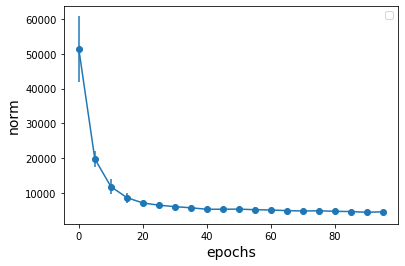

In [0]:
mean_norm = np.mean(norm1_list, axis = 0)
std_norm  = np.std(norm1_list, axis = 0)
plt.errorbar(x = np.arange(0, num_epochs, 5), y = mean_norm, yerr = std_norm, marker = 'o')
plt.xlabel("epochs", fontsize = 14)
plt.ylabel("norm", fontsize = 14)
plt.legend()
plt.show()

No handles with labels found to put in legend.


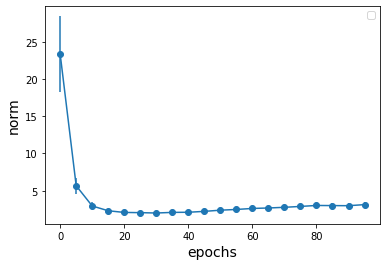

In [0]:
mean_norm = np.mean(norm2_list, axis = 0)
std_norm  = np.std(norm2_list, axis = 0)
plt.errorbar(x = np.arange(0, num_epochs, 5), y = mean_norm, yerr = std_norm, marker = 'o')
plt.xlabel("epochs", fontsize = 14)
plt.ylabel("norm", fontsize = 14)
plt.legend()
plt.show()

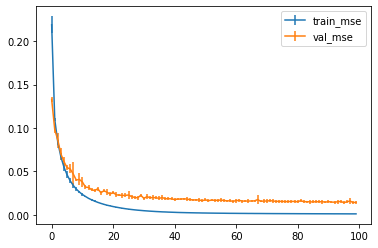

In [0]:
mean_mse = np.mean(train_mse, axis = 0).flatten().tolist()
std_mse  = np.std(train_mse, axis = 0).flatten().tolist()
plt.errorbar(x = np.arange(0, num_epochs), y = mean_mse, yerr = std_mse, label = "train_mse")

mean_mse = np.mean(val_mse, axis = 0).flatten().tolist()
std_mse  = np.std(val_mse, axis = 0).flatten().tolist()
plt.errorbar(x = np.arange(0, num_epochs), y = mean_mse, yerr = std_mse, label = "val_mse")
plt.legend()
plt.show()